In [1]:
import cooler
import numpy as np
import pandas as pd
from scipy.sparse import triu
from scipy.stats import pearsonr, zscore, norm
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns

In [2]:
ct = 'Oligo_NN'
ages = ['8wk','9mo','18mo']
leg = [f"{ct}.{age}" for age in ages]
leg

['Oligo_NN.8wk', 'Oligo_NN.9mo', 'Oligo_NN.18mo']

In [3]:
ctgroup = [[_leg] for _leg in leg]
ctgroup

[['Oligo_NN.8wk'], ['Oligo_NN.9mo'], ['Oligo_NN.18mo']]

In [4]:
indir = '/data/female-amb/loop/'
outdir = f'loop_ct_age/diff/{ct}'
res = 10000
group = ct

In [5]:
chrom_size_path = f'/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)

## load loop position and anova

In [6]:
loopall = [pd.read_csv(f'{indir}/{ct_age}/{ct_age}/{ct_age}.loop.bedpe', sep='\t', index_col=None, header=None) for ct_age in leg]
loopall = pd.concat(loopall, axis=0)
loopall = loopall.drop([6], axis=1).drop_duplicates(subset=[0,1,4]).sort_values([0,1,4])
loopall = pd.concat([loopall[(loopall[0]==c).values] for c in chrom_sizes.index[:-1]])
loopall.index = np.arange(loopall.shape[0])
loopall

,0,1,2,3,4,5
0,chr1,3110000,3120000,chr1,3650000,3660000
1,chr1,3190000,3200000,chr1,3440000,3450000
2,chr1,3190000,3200000,chr1,3450000,3460000
3,chr1,3200000,3210000,chr1,3360000,3370000
4,chr1,3200000,3210000,chr1,3370000,3380000
...,...,...,...,...,...,...
328123,chr19,59460000,59470000,chr19,60310000,60320000
328124,chr19,59460000,59470000,chr19,60320000,60330000
328125,chr19,59460000,59470000,chr19,60330000,60340000
328126,chr19,59460000,59470000,chr19,60380000,60390000


In [7]:
import pathlib
p = pathlib.Path(f"{outdir}")
p.mkdir(exist_ok = True)

In [8]:
loopall.to_csv(f'{outdir}/merged_loop.bedpe', sep='\t', index=False, header=False)
loopall.to_hdf(f'{outdir}/merged_loop.hdf', key='data')

In [9]:
for c in chrom_sizes.index[:-1]:
    loopfilter = (loopall[0]==c)
    looptmp = loopall.loc[loopfilter, [1,4]].values // res
    for matrix in ['Q', 'E', 'T']:
        cool = cooler.Cooler(f'{outdir}/{matrix}pv.cool')
        pv = triu(cool.matrix(balance=False, sparse=True).fetch(c)).tocsr()
        loopall.loc[loopfilter, f'{matrix}anova'] = pv[(looptmp[:,0], looptmp[:,1])].A1

In [10]:
loopall.to_hdf(f'{outdir}/merged_loop.hdf', key='data')

## load loop Q

In [11]:
loopall = pd.read_hdf(f'{outdir}/merged_loop.hdf', key='data')
loopall

,0,1,2,3,4,5,Qanova,Eanova,Tanova
0,chr1,3110000,3120000,chr1,3650000,3660000,4.277250,7.140894,0.364377
1,chr1,3190000,3200000,chr1,3440000,3450000,0.089684,4.566628,0.401627
2,chr1,3190000,3200000,chr1,3450000,3460000,1.310871,7.336428,0.280264
3,chr1,3200000,3210000,chr1,3360000,3370000,3.286088,6.090084,1.342627
4,chr1,3200000,3210000,chr1,3370000,3380000,3.805864,8.528182,2.405510
...,...,...,...,...,...,...,...,...,...
328123,chr19,59460000,59470000,chr19,60310000,60320000,1.108318,0.187264,2.239202
328124,chr19,59460000,59470000,chr19,60320000,60330000,0.372183,0.766853,1.249559
328125,chr19,59460000,59470000,chr19,60330000,60340000,0.137374,0.505292,0.868124
328126,chr19,59460000,59470000,chr19,60380000,60390000,0.807607,10.110734,6.911905


In [12]:
def load_Q(ct_age, m):
    tmp = []
    cool_file = cooler.Cooler(f'{indir}/{ct_age}/{ct_age}/{ct_age}.{m}.cool').matrix(balance=False, sparse=True)
    for c in chrom_sizes.index[:-1]:
        mat = cool_file.fetch(c).tocsr()
        tmp.append(mat[(loopall.loc[loopall[0]==c, 1].values // res, loopall.loc[loopall[0]==c, 4].values // res)].A1)
        # print(ct, c)
    return [ct_age, np.concatenate(tmp)]

In [13]:
cpu = 20
with ProcessPoolExecutor(cpu) as executor:
    futures = []
    for xx in leg:
        future = executor.submit(
            load_Q,
            ct_age=xx,
            m='Q'
        )
        futures.append(future)

    loopq = []
    for future in as_completed(futures):
        tmp = future.result()
        loopq.append(pd.DataFrame(tmp[1], columns=[tmp[0]]))
        print(f'{tmp[0]} finished')

Oligo_NN.8wk finished
Oligo_NN.9mo finished
Oligo_NN.18mo finished


In [14]:
loopq = pd.concat(loopq, axis=1)
loopq = loopq[leg]

In [15]:
loopq.to_hdf(f'{outdir}/loop_Q.hdf', key='data')

In [16]:
cpu = 20
with ProcessPoolExecutor(cpu) as executor:
    futures = []
    for xx in leg:
        future = executor.submit(
            load_Q,
            ct_age=xx,
            m='T'
        )
        futures.append(future)

    loopt = []
    for future in as_completed(futures):
        tmp = future.result()
        loopt.append(pd.DataFrame(tmp[1], columns=[tmp[0]]))
        print(f'{tmp[0]} finished')
        

Oligo_NN.9mo finished
Oligo_NN.8wk finished
Oligo_NN.18mo finished


In [17]:
loopt = pd.concat(loopt, axis=1)
loopt = loopt[leg]

In [18]:
loopt.to_hdf(f'{outdir}/loop_T.hdf', key='data')

In [19]:
loopq = pd.read_hdf(f'{outdir}/loop_Q.hdf', key='data')
loopt = pd.read_hdf(f'{outdir}/loop_T.hdf', key='data')

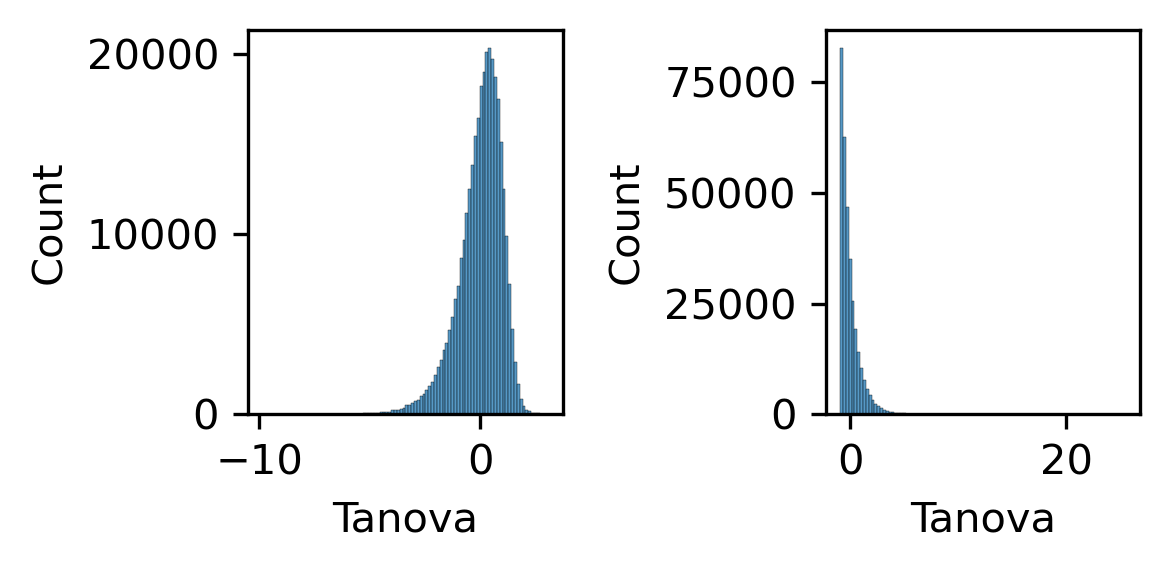

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300)
ax = axes[0]
sns.histplot(zscore(np.log10(loopall['Tanova'])), bins=100, ax=ax)
ax = axes[1]
sns.histplot(zscore(loopall['Tanova']), bins=100, ax=ax)
plt.tight_layout()

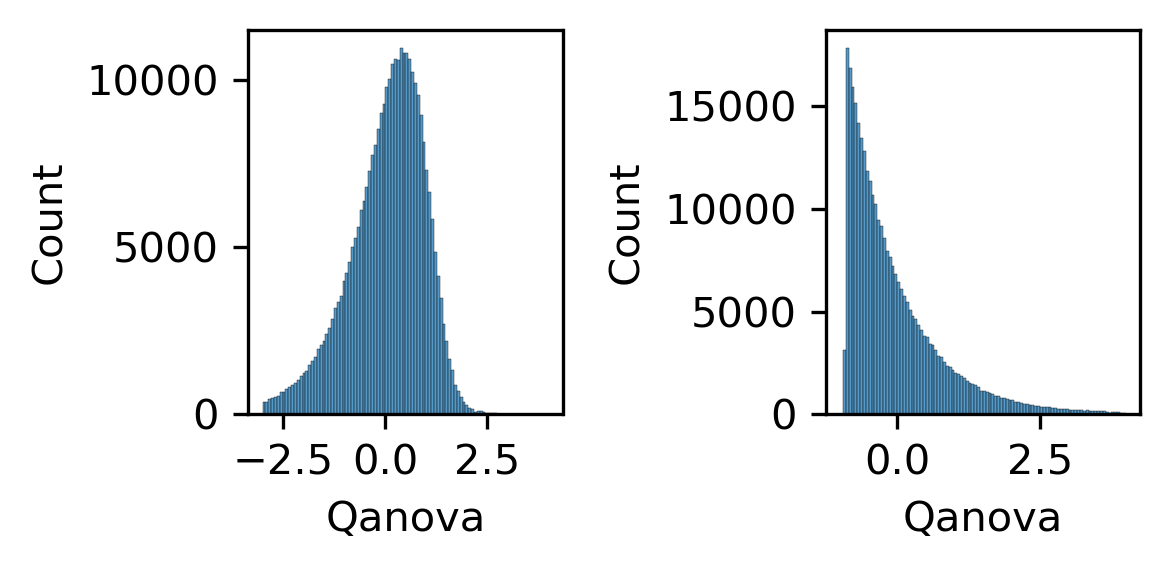

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300)
ax = axes[0]
sns.histplot(zscore(np.log10(loopall['Qanova'])), bins=100, binrange=(-3,4), ax=ax)
ax = axes[1]
sns.histplot(zscore(loopall['Qanova']), bins=100, binrange=(-1,4), ax=ax)
plt.tight_layout()

In [22]:
thres1 = norm.isf(0.025)
thres2 = norm.isf(0.15)
print(thres1, thres2)

1.9599639845400545 1.0364333894937898


In [23]:
selb = ((zscore(loopall['Qanova'])>thres2) & (zscore(loopall['Tanova'])>thres2))

In [24]:
tmpq = loopq.loc[selb].values
tmpq = zscore(tmpq, axis=1)

In [25]:
tmpt = loopt.loc[selb].values
tmpt = zscore(tmpt, axis=1)

In [26]:
np.random.seed(0)
sel = np.random.choice(np.arange(len(tmpq)), 2000, False)

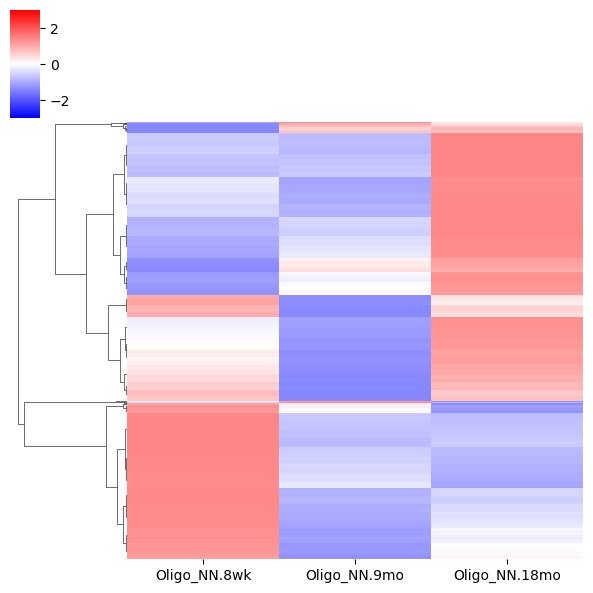

In [27]:
cg = sns.clustermap(tmpq[sel], cmap='bwr', vmin=-3, vmax=3, metric='cosine', 
                    col_cluster=False,xticklabels=leg, yticklabels=[], figsize=(6,6))

In [28]:
rorder = cg.dendrogram_row.reordered_ind.copy()
#corder = cg.dendrogram_col.reordered_ind.copy()

NameError: name 'corder' is not defined

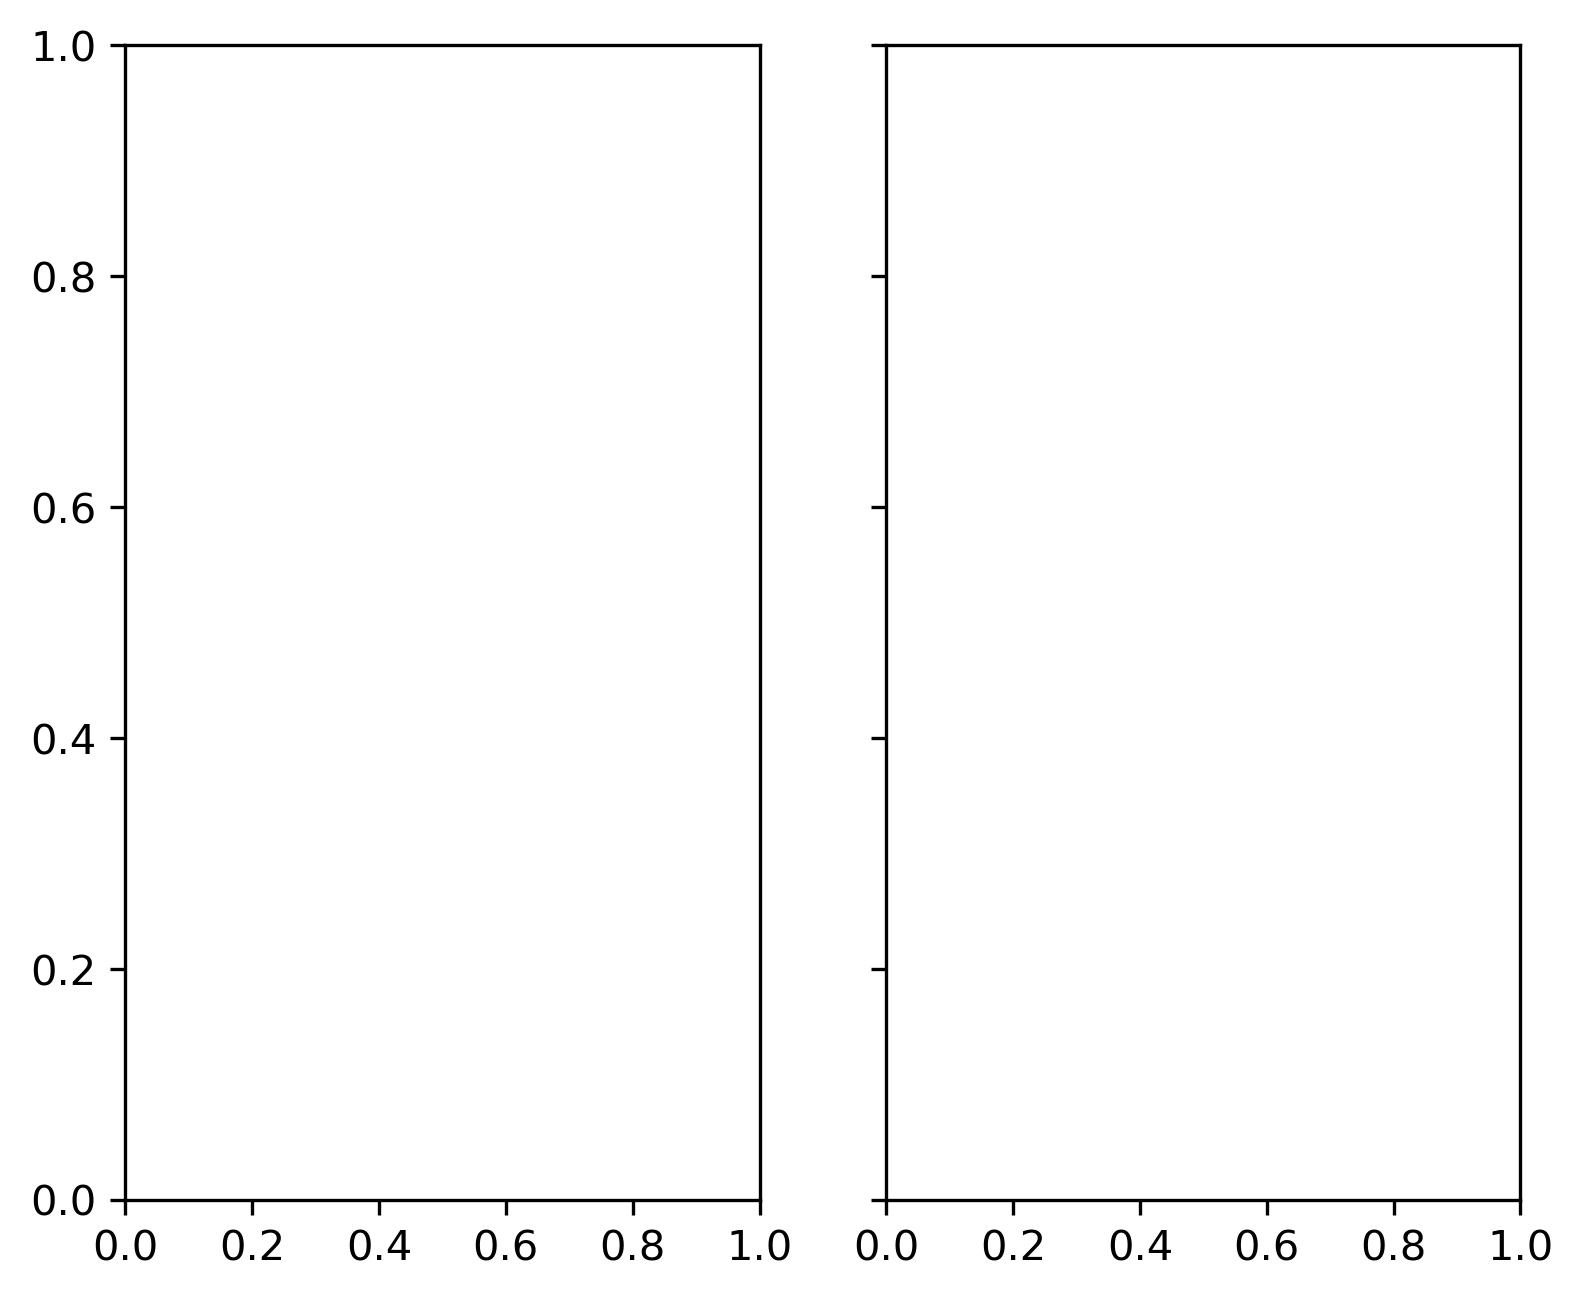

In [29]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6, 5), dpi=300)

ax = axes[0]
ax.imshow(tmpq[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Q', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(labels = leg, rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{tmpq.shape[0]} Diff Loop')

ax = axes[1]
ax.imshow(tmpt[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('T', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(labels = leg,rotation=90)

plt.tight_layout()